# Set up environment and read in data

In [1]:
# mount drive to access csv saved in /data
from google.colab import drive
drive.mount('/content/gdrive')

# load spaCy dependencies
!pip install --upgrade spacy # upgrade spacy in order to load the job_description.spacy file 
import spacy
from spacy.tokens import Doc, DocBin
from spacy.vocab import Vocab
!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")
from spacy.matcher import Matcher

from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from wordcloud import wordcloud
import matplotlib.pyplot as plt
import re


Mounted at /content/gdrive
     |████████████████████████████████| 6.0 MB 9.9 MB/s 
     |████████████████████████████████| 628 kB 37.9 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 181 kB 48.9 MB/s 
     |████████████████████████████████| 451 kB 35.8 MB/s 
     |████████████████████████████████| 10.1 MB 34.1 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |█████████████

In [2]:
 print(spacy.__version__)

3.2.1


**bold text**# TO DO: - SHOUULD BE REMOVED 



1. Preproccessing
  - [X] Verify data (Oliver) 
  - [X] Format dtypes (if timestamp is string, convert to Pandas time object, etc.) (Oliver)
  - [x] Define tokenization method (spaCy, nltk, etc.)
  - [x] Drop columns

2. exploratory analysis 
  - [ ] Try to make a binary split of entry-level vs. not entry-level 
  - [ ] Try to find subcategories of position title (junior data scientist, senior data scientist, etc.) for later comparative analysis
  - [ ] Extract: (new col for each)
    - skills (programming languages etc.) (Bruno)
    - soft skills (Bruno)
    - degree (masters/bachealors) (Bruno)
    - verbs (Bruno)
    - adverbs 
    - years of experience (Bruno)
    - web addresses
     

3. Visualizations
  - [ ] Visualize results and interpret conclusions
  - [ ] 

Note: 

Performing population statistics would be tempting, however, data may not be a 'random' sample due to crawler functionality


# Preprocessing

## Read the data

In [3]:
# read in data
url = '/content/gdrive/Shareddrives/IST_736_Text_Mining/data/data_scientist_united_states_job_postings_jobspikr.csv'
data = pd.read_csv(url)
# there should be exaclty 10k rows, there are 7 extra
print(data.shape) 
data.head(2)


(10007, 22)


crawl_timestamp  ... html_job_description
0  2019-02-06 05:26:22 +0000  ...                  NaN
1  2019-02-06 05:33:41 +0000  ...                  NaN

[2 rows x 22 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10007 entries, 0 to 10006
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   crawl_timestamp       10004 non-null  object 
 1   url                   10003 non-null  object 
 2   job_title             10002 non-null  object 
 3   category              9118 non-null   object 
 4   company_name          10000 non-null  object 
 5   city                  9752 non-null   object 
 6   state                 9585 non-null   object 
 7   country               10000 non-null  object 
 8   inferred_city         8980 non-null   object 
 9   inferred_state        9485 non-null   object 
 10  inferred_country      9505 non-null   object 
 11  post_date             10000 non-null  object 
 12  job_description       10000 non-null  object 
 13  job_type              9999 non-null   object 
 14  salary_offered        597 non-null    object 
 15  job_board          

## Drop unwanted columns

In [5]:
# Drop unwanted columns
cols_to_drop =['crawl_timestamp',
               'country',
               'inferred_city',
               'inferred_state',
               'inferred_country',
               'geo',
               'cursor',
               'contact_email',
               'contact_phone_number',
               'html_job_description']

data = data.drop(columns=cols_to_drop)
print(data.shape)
data.head(3)

(10007, 12)


url  ...                           uniq_id
0  https://www.indeed.com/viewjob?jk=fd83355c2b23...  ...  3b6c6acfcba6135a31c83bd7ea493b18
1  https://www.dice.com/jobs/detail/Data-Scientis...  ...  741727428839ae7ada852eebef29b0fe
2  https://www.dice.com/jobs/detail/Data-Scientis...  ...  cdc9ef9a1de327ccdc19cc0d07dbbb37

[3 rows x 12 columns]

## Verify Data Integrity

In [6]:
# find the broken rows and fix them

# ID column should have no NAs
data_broken = data[data.uniq_id.isna()]
print(data_broken.shape)

# looking at the values, it seems this one post was broken into many. dropping these rows would fix this
print(data_broken.values) 

# dropping the 8 bad rows, results in only losing 1 row of data
data = data.dropna(subset=['uniq_id']) 

print(data.shape)

(8, 12)
[['https://www.indeed.com/viewjob?jk=64f8b996d5da838a'
  'Operations Research Analyst (Data Scientist)' 'Computer-or-internet'
  'US Department of the Army' 'Austin' 'TX' '6/14/2019'
  'Read what people are saying about working here. \n\nDuties\n\nSummary\n\nAbout the Position: This position serves as an Operations Research Analyst (Data Scientist) in Army Futures Command (AFC), Data Science Cell, located in Austin, Texas. AFC exists to modernize the way the Army does business by creating a space of endless possibilities to explore, develop, and test new methods, organizations, and technologies. Visit us on www.armyfuturescommand.com and join the team leading the Army into the future!"\n\nResponsibilities\n\nServe as a Data Scientist and staff advisor with direct responsibility of performance within the Data Science Cell devoted to producing agile and dynamic analytics that enable decision-making through the Army\'s modernization enterprise.\n\nDevelop command-driven analytics 

In [7]:
# each ID should be same length, otherwise, it may be an indication of broken data
print(len(data.uniq_id[0])) 

# compute length of each ID and store in list
id_lengths = data.uniq_id.str.len().values.tolist() 

# confirm all IDs are the same length
print(set(id_lengths)) 

32
{32}


In [8]:
# check for duplicate rows
data_unique = data.drop_duplicates()
data_unique.shape

(9965, 12)

In [9]:
# Get count of NANs
data.isna().sum()

url                   0
job_title             0
category            882
company_name          1
city                249
state               416
post_date             0
job_description       0
job_type              0
salary_offered     9402
job_board           690
uniq_id               0
dtype: int64

# Exploratory Analysis

## Feature Distributions

### Number of different job boards

job_board
indeed           4954
careerbuilder    2033
monster          1866
NaN               690
dice              445
Stackoverflow       7
totaljob            2
simplyhired         2
dtype: int64


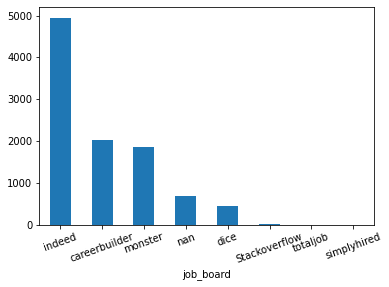

In [10]:
# num different job boards
job_boards = data.groupby(by=['job_board'], dropna=False).size().sort_values(ascending=False)

# there are 8 different job boards included
print(job_boards)
job_boards.plot.bar(rot=20)

### Range of Salaries

In [11]:
# Salaries
salaries = data.groupby(by=['salary_offered'], dropna=True).size().sort_values(ascending=False)
salaries.head(15)

salary_offered
$80K - $100K                             405
$100K - $150K                            109
$150K - $200K                             36
$200K - $250K                             15
$85k - 97k | Equity                        5
$150k - 175k | Equity                      4
$80K - $150K                               3
$50k - 75k | Equity                        3
$250K - $500K                              3
$100k - 135k | Equity                      3
$200K - $2147484K                          2
$120K - $140K                              1
$100K - $230K                              1
$120000 - $140000 per annum + Package      1
Salary Range:    Undisclosed               1
dtype: int64

### Type of Job Categories

In [12]:
categories = data.groupby(by=['category'], dropna=True).size().sort_values(ascending=False)
print(len(categories))
categories.head(20)



366


category
Computer-or-internet                 1504
computer jobs                         911
life physical and social science      758
Engineering-or-architecture           729
Manufacturing-or-mechanical           632
business and financial operations     616
math jobs                             582
Computer/Internet                     467
Engineering/Architecture              324
Data Scientist                        223
Manufacturing/Mechanical              159
Accounting-or-finance                 155
Administrative                        135
Accounting/Finance                    129
architecture and engineering          111
Sales                                  93
Customer-Service                       78
Senior Data Scientist                  77
Government-or-military                 75
Arts/Entertainment/Publishing          72
dtype: int64

### Confirm if evey job post is unique

In [13]:
# Check if there's repeat postings

description_unique = data.groupby(by=['job_description'], dropna=False).size().sort_values(ascending=False)
print('Number of unique job descriptions: ',description_unique.shape[0])


Number of unique job descriptions:  7737


## Group Jobs Posts

### Group Posts by Seniority 

In [14]:
# Create new feature to indicate whether not job posting is senior level
pat = '(sr|senior)|(iii|3)|(lead|principal)|( iv|manager)'

def check_if_senior(x):
  title = x.job_title
  
  # find senior posts
  if bool(re.search(pat, 
                    title, 
                    flags=re.IGNORECASE)):
    return 'senior'
  
  # find junior posts
  elif re.search('(jr|junior)|( i | i,)|(intern| i$)', 
                 title, 
                 flags=re.IGNORECASE):
    return 'entry/junior'
  elif re.search('entry level',
                 x.job_description,
                 flags = re.IGNORECASE):
    return 'entry/junior'
  
  # find posts where title is only 'Data Scientist'
  elif re.search('^data scientist$', 
                 title,
                 flags=re.IGNORECASE):
    return 'title_only_data_scientist'
  
  else:
    return 'other'

data['seniority_level'] = data.apply(check_if_senior, axis = 1)

data.groupby('seniority_level').size().sort_values(ascending=False)

seniority_level
other                        3315
senior                       3278
title_only_data_scientist    2885
entry/junior                  521
dtype: int64

### Group Posts

In [15]:
# Get distinct job categories

data.groupby(by=['category'], dropna=False).size().sort_values(ascending=False)

category
Computer-or-internet                                               1504
computer jobs                                                       911
NaN                                                                 882
life physical and social science                                    758
Engineering-or-architecture                                         729
                                                                   ... 
Principal Data Scientist - NLP                                        1
Principal Data Scientist - Grid Intelligence (Exelon Utilities)       1
Principal Data Scientist - Direct Store Delivery (DSD)                1
Principal Applied Data Scientist - Machine Learning                   1
AI Data Scientist - Machine Learning                                  1
Length: 367, dtype: int64

# Create spaCy Pipeline
- Since it takes extremely long to process each document using the nlp(job_description), The text has all been converted into the spaCy doc objects and saved to a file called job_descriptions.spacy. 
- Do Not uncomment the below code that processes, serializes, and saves the output to disk. It takes >30mins to finish on the Google Colab machine. It's much easier to load in the processed documents and go from there.

To access the `Doc` object stored within the `DocBin`, you must use the **get_docs()** method.

The **get_docs()** method takes a single argument, `vocab`, which takes the vocabulary of a Language object as input.

The vocabulary, which is stored under the vocab attribute of a Language object, is needed to reconstruct the information stored in the `DocBin`

In [16]:
# Process all job descriptions and save to file

# Process all docs (takes extremely long time)
#docs = list(nlp.pipe(data.job_description.values, n_process=-1))

# Serialize
#doc_bin = DocBin(docs = docs)

# Save To Disk
#doc_bin.to_disk("./job_descriptions.spacy")

# Read in saved doc objects
loaded_docs_bin = DocBin().from_disk('/content/gdrive/Shareddrives/IST_736_Text_Mining/data/job_descriptions_lg.spacy')
loaded_docs = list(loaded_docs_bin.get_docs(nlp.vocab))

# insert doc objects to pandas df
data['job_dscrptn_docs'] = loaded_docs

## spacy exploration

### function to remove stop_words,punctations,numbers and store as column named `clean_job_dscrptn_docs`

In [17]:
#removing stopwords and punctuation
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import string
punctuations = string.punctuation

In [18]:
#created a function that remove stop_words,punctations,numbers save as a 'clean_job_dscrptn_docs'
def rem_stop_punct(row):
  clean_words = [word for word in row['job_dscrptn_docs'] if (word.is_stop == False and word.is_punct == False and word.is_alpha == True)]
  return clean_words

data['clean_job_dscrptn_docs'] = data.apply(rem_stop_punct, axis=1)
print(data['clean_job_dscrptn_docs'][1])


[immediate, opening, Sharp, Data, Scientist, strong, Mathematical, Statistical, background, work, initiatives, Huge, data, environment, looking, formats, Data, dealing, Billing, Fraud, Patterns, software, modeling, techniques, candidate, minimum, years, solid, work, experience, professional, organization, corporation, Python, SQL, Python, libraries, Machine, Learning, Algorithms, Decision, Tree, Random, Forest, Logistic, Regression, etc, strong, Python, skills, Additional, experience, R, Cloud, plus, working, structured, unstructured, data, formats, experience, Hive, Big, Data, technologies, plus, strong, communication, skills, ability, explain, data, findings, Technical, Technical, audiences, considering, Recent, College, minimum, post, Graduate, experience, working, professional, organization]


In [19]:
data[:1]

url  ...                             clean_job_dscrptn_docs
0  https://www.indeed.com/viewjob?jk=fd83355c2b23...  ...  [Read, people, saying, working, Farmers, Join,...

[1 rows x 15 columns]

### function to select the NOUNs from the `clean_job_dscrptn_docs` and store as `noun_list`

In [20]:
# noun tokens that arent stop words or punctuations 

noun_list = [] ## ### oliver added to create a flat list 
def get_noun(row):
  #noun_words = [word for word in row['job_dscrptn_docs'] if (word.is_stop == False and word.is_punct == False and word.is_alpha == True and word.pos_ =="NOUN")]
  noun_words = [word.lower_ for word in row['clean_job_dscrptn_docs'] if (word.pos_ =="NOUN")]
  noun_list.append(noun_words)
  return (noun_words)

data['noun_list'] = data.apply(get_noun, axis=1)
print(data['noun_list'][:1])


0    [people, team, professionals, skills, job, kno...
Name: noun_list, dtype: object


### count of the top 20 NOUNs

### function to count the NOUNs the column ` noun_list` save as dictionary

In [21]:
from collections import Counter
import operator

# most common nouns as a dictionay
def get_top_noun(row):
  noun_freq = Counter(row['noun_list'])
  common_nouns = dict(noun_freq.most_common())
  common_nouns_sorted = sorted(common_nouns.items(), key=operator.itemgetter(1),reverse=True)
  return (common_nouns)

# apply to the complete dataset 
data['common_nouns'] = data.apply(get_top_noun, axis=1)
print(data['common_nouns'][:1])

# to access only the items in the dictionary
#data['common_nouns'][1].items()

0    {'data': 8, 'team': 3, 'training': 3, 'analysi...
Name: common_nouns, dtype: object


In [22]:
flat_nouns = [item for sublist in noun_list for item in sublist]
noun_series = pd.DataFrame(flat_nouns)
#verb_list = [i.join() for i in verb_list]
noun_series.value_counts()[:20] # oliver, cound of the top 20 verbs

data           99419
experience     54126
business       31336
team           19793
analysis       19192
learning       17599
skills         16679
models         16110
years          16094
machine        16071
analytics      16031
science        15866
ability        15080
solutions      14346
tools          12498
knowledge      11872
development    11669
techniques     11387
work           10975
information    10162
dtype: int64

### function to select the VERBs and store as `verb_words`

In [23]:
# noun tokens that arent stop words or punctuations 
verb_list = [] ## ### oliver added to create a flat list 
def get_verb(row):
  verb_words = [word.lemma_ for word in row['clean_job_dscrptn_docs'] if (word.pos_ =="VERB")]
  verb_list.append(verb_words) ### oliver added to create a flat list 
  return (verb_words)

data['verb_list'] = data.apply(get_verb, axis=1)
print(data['verb_list'][:1])

0    [read, say, work, join, acquire, apply, learn,...
Name: verb_list, dtype: object


### Count of the top 20 VERBs 

In [24]:
#verb_list_flat = ' '.join([text for text in verb_list]) ## trying to flat the list , no success 
flat = [item for sublist in verb_list for item in sublist]
verb_series = pd.DataFrame(flat)
#verb_list = [i.join() for i in verb_list]
verb_series.value_counts()[:20] # oliver, count of the top 20 verbs

work          30016
develop       18398
include       15911
build         12646
provide       12412
apply         11485
require       11420
drive         10863
help           9340
create         8536
solve          7717
support        7315
identify       7303
learn          7140
lead           7071
base           6752
deliver        6585
analyze        6538
need           6074
understand     5982
dtype: int64

### function to count the VERBs and store as a dictionary ` verb_list` 

In [25]:
from collections import Counter
import operator

# most common nouns as a dictionay
def get_top_verb(row):
  verb_freq = Counter(row['verb_list'])
  common_verbs = dict(verb_freq.most_common())
  common_verbs_sorted = sorted(common_verbs.items(), key=operator.itemgetter(1),reverse=True)
  return (common_verbs)

# apply to the complete dataset 
data['common_verbs'] = data.apply(get_top_verb, axis=1)
print(data['common_verbs'][:1])

# to access only the items in the dictionary
#data['common_verbs'][1].items()

0    {'work': 2, 'provide': 2, 'read': 1, 'say': 1,...
Name: common_verbs, dtype: object


### word map visualization 

In [26]:
data['common_nouns'][1].items()

dict_items([('data', 4), ('experience', 4), ('formats', 2), ('minimum', 2), ('organization', 2), ('skills', 2), ('plus', 2), ('opening', 1), ('background', 1), ('initiatives', 1), ('environment', 1), ('software', 1), ('modeling', 1), ('techniques', 1), ('candidate', 1), ('years', 1), ('work', 1), ('corporation', 1), ('libraries', 1), ('technologies', 1), ('communication', 1), ('ability', 1), ('findings', 1), ('audiences', 1), ('post', 1), ('graduate', 1)])

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize(word_map_dic, word):
  occurrences = []
  ranks = []
  word_rank = 0
  word_frequency = 0

  rank = 1
  for item in data['common_nouns'][0].items():
    if (item[0] == word):
      word_rank = rank
      word_frequency = item[1]

    ranks.append(rank)
    rank += 1
    occurrences.append(item[1])
  #return occurrences, ranks, word_rank, word_frequency

  plt.title('Word frequencies')
  plt.ylabel('Total number of occurences')
  plt.xlabel("Word ranks ( rank of word \"" + word + "\" is " + str(word_rank) + ")")

  # logarithms help present the frequency/rank information concisely

  plt.loglog(ranks, occurrences,basex = 10)
  plt.scatter(
      [word_rank],
      [word_rank],
      color = 'red',
      marker = 'x',s=100, label=word
  )
  plt.show()

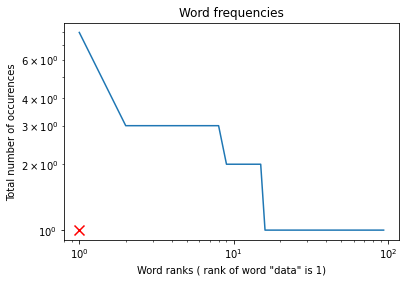

In [28]:
visualize(data['common_nouns'][2],'data')

## Phrase Matching

1. Import the Phrasematcher function from spacy ;
2. Create Phrasematcher object 
3. Convert each phrase to a `doc`object.
4. Pass each `doc`object into the matter
3. Define patterns to add to the matcher
4. add the pattern to the matcher 

In [29]:
from spacy.matcher import PhraseMatcher

In [30]:
matcher = PhraseMatcher(nlp.vocab)

In [31]:
#to remove matcher, if necessary
#matcher.remove('Skills')

In [32]:
# create phrase matchers for computer language and skills
computer_languages_list = ['Python', 'Python libraries','R','R Cloud', 'SQL','Python Basic','machine learning techniques', 'ETS', 'decision trees','neural networks',
               'ensemble methods','cluste ring','Java','Java Script', 'Scala', 'HTML','CSS', 'NoSQL', 'C+','C++','Rust',
               'Perl', 'Go','Ruby','PHP', 'Dart','hadoop', 'Spark','TensorFlow', 'BI','Power BI', ]

personal_skills_list = ['Cloud Computing','Machine Learning','Data Wrangling','Data Exploration','Advanced mathematics','Statistics','Probability',
                        'Database management','Visualizations', 'Communication','Presentation','Storytelling',
                        'Problem Solving', 'Critical Thinking']



computer_languages_patterns = [nlp(text) for text in computer_languages_list]
personal_skills_patterns = [nlp(text) for text in personal_skills_list]

matcher.add('computer languages', None,*computer_languages_patterns)
matcher.add('personal skills', None,*personal_skills_patterns)

#### Function to apply **matcher**  to each column

##### function to apply **matcher** and store the `phrase_matches_skills`

In [33]:
def get_matches_skills(row):
  found_matches_per_skills = []
  found_matches = [match for match in matcher(row['job_dscrptn_docs'])]
  for m in found_matches:
    if nlp.vocab.strings[m[0]]=='personal skills':
        found_matches_per_skills.append(m)
  return(len(found_matches_per_skills))

#data.drop(columns=['phrase_matches'], axis=1) # if needed to drop 
data['phrase_matches_skills'] = data.apply(get_matches_skills, axis = 1)
data['phrase_matches_skills'][:5]

0    0
1    1
2    0
3    0
4    0
Name: phrase_matches_skills, dtype: int64

In [34]:
#pd.get_dummies(data['phrase_matches_lang']).head()

In [35]:
#binary 
def is_matches_skills(row):
  is_skill = 0
  found_matches_per_skills = []
  found_matches = [match for match in matcher(row['job_dscrptn_docs'])]
  for m in found_matches:
    if nlp.vocab.strings[m[0]]=='personal skills':
        found_matches_per_skills.append(m)
    if len(found_matches_per_skills) >= 1:
      is_skill = 1
    else:
      is_skill = 0
  return(is_skill)

#data.drop(columns=['phrase_matches'], axis=1) # if needed to drop 
data['is_matches_skills'] = data.apply(is_matches_skills, axis = 1)
data['is_matches_skills'][:5]

0    0
1    1
2    0
3    0
4    0
Name: is_matches_skills, dtype: int64

##### function to apply **matcher** and store the `phrase_matches_lang`

In [36]:
def get_matches_com_lang(row):
  found_matches_com_lang = []
  found_matches = [match for match in matcher(row['job_dscrptn_docs'])]
  for m in found_matches:
      if nlp.vocab.strings[m[0]]=='computer languages':
        found_matches_com_lang.append(m)
  return(len(found_matches_com_lang))
  
#data.drop(columns=['phrase_matches'], axis=1) # if needed to drop 
data['phrase_matches_lang'] = data.apply(get_matches_com_lang, axis = 1)
data['phrase_matches_lang'][:5]

0    10
1     7
2     7
3     5
4     3
Name: phrase_matches_lang, dtype: int64

In [37]:
#binary 
def is_matches_com_lang(row):
  is_matches_com_lang = 0
  found_matches_com_lang = []
  found_matches = [match for match in matcher(row['job_dscrptn_docs'])]
  for m in found_matches:
    if nlp.vocab.strings[m[0]]=='computer languages':
        found_matches_com_lang.append(m)
    if len(found_matches_com_lang) >= 1:
      is_matches_com_lang = 1
    else:
      is_matches_com_lang = 0
  return(is_matches_com_lang)

#data.drop(columns=['phrase_matches'], axis=1) # if needed to drop 
data['is_matches_com_lang'] = data.apply(is_matches_com_lang, axis = 1)
data['is_matches_com_lang'][:5]

0    1
1    1
2    1
3    1
4    1
Name: is_matches_com_lang, dtype: int64

### Function that counts the number of sentences for each post

In [38]:
def get_sentences(row):
  sentences_list = []
  found_sentences = [sent for sent in row['job_dscrptn_docs'].sents]
  return(len(found_sentences))

data['count_sentences'] = data.apply(get_sentences, axis = 1)
data['count_sentences'][:5]


0    23
1     7
2     1
3    26
4    20
Name: count_sentences, dtype: int64

# Knowledge Graph

This section is modified from a notebook created by Pavan Sanagapati on Kaggle. It looks like the code may have originated from Nagesh Singh Chauhan. 

Using spaCy POS tags, extract the single word entity. These entities are the nouns and proper nouns. 

## Preprocess for Knowledge Graph

In [39]:
# Read in saved doc objects
filename = '/content/gdrive/Shareddrives/IST_736_Text_Mining/data/sentence_docs.spacy'
loaded_sents_bin = DocBin().from_disk(filename)
loaded_sents = list(loaded_sents_bin.get_docs(nlp.vocab))
docs_idx = pd.read_csv('/content/gdrive/Shareddrives/IST_736_Text_Mining/data/sentence_idx.csv')
docs_idx = docs_idx.drop(columns='Unnamed: 0')
docs_idx = docs_idx.values
docs_idx

array([[     0,     23],
       [    23,     30],
       [    30,     31],
       ...,
       [294052, 294081],
       [294081, 294091],
       [294091, 294101]])

In [40]:
# restore data structure
reshaped_docs = []

for start, stop in docs_idx:
    post_sents = loaded_sents[start:stop]
    reshaped_docs += [post_sents]

In [41]:
# split each job description to a list of sentences
docs_sentences = []

docs = data.job_dscrptn_docs.to_list()

In [42]:
#out_csv = '/content/gdrive/Shareddrives/IST_736_Text_Mining/data/sents.csv'
#sents_df = pd.DataFrame(docs_sentences)
#sents_df.to_csv(out_csv, index=False)

## Map entities and relationships

In [43]:
from tqdm import tqdm

# source: https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

def get_entities(sent):
  """extract the subject and the object (entities) from a sentence"""
  
  ## prv_tok_dep and prv_tok_text will hold the dependency tag of the previous 
  ## word in the sentence and that previous word itself, respectively. 
  ## prefix and modifier will hold the text that is associated with the subject 
  ## or the object.
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  
  for tok in sent: # Loop through the tokens in this sentemnce
    
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      ## if the token is the subject, then it will be captured as the first 
      ## entity in the ent1 variable. Variables such as prefix, modifier, 
      ## prv_tok_dep, and prv_tok_text will be reset
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      ## if the token is the object, then it will be captured as the second 
      ## entity in the ent2 variable. Variables such as prefix, modifier, 
      ## prv_tok_dep, and prv_tok_text will again be reset
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      # chunk 5
      ## Once we have captured the subject and the object in the sentence, 
      ## we will update the previous token and its dependency tag. 
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  

  return [ent1.strip(), ent2.strip()]

In [44]:
docs = data.job_dscrptn_docs.to_list()
#docs_flat = [list(i.sents) for i in docs]
#len(docs_flat[0])
entity_pairs = [get_entities(sent) for sent in loaded_sents]

In [45]:
from spacy.matcher import Matcher
def get_relation(sent_input):
  """To build a knowledge graph, we need edges to connect the nodes (entities) 
  to one another. These edges are the relations between a pair of nodes."""
  #doc = nlp(sent)
  
  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  if not isinstance(sent_input, spacy.tokens.doc.Doc):
    return 
  
  matches = matcher(sent_input)
  
  if len(matches) < 1:
    return 
  try:
    k = len(matches) - 1
    span_start = matches[k][1]
    span_end = matches[k][2]
  except IndexError:
    print('sent: ', sent_input,
          '\nmatches: ', matches)

  span = sent_input[span_start:span_end] 

  return(span.text)

In [46]:
# Now we can process all of the sentences again to get the relation

relations = [get_relation(sent) for sent in loaded_sents]

In [47]:
# display an exmple
relations_series = pd.Series(relations)

exp_idxs = relations_series[relations_series == 'Experience'].index

tmp = loaded_sents[exp_idxs[1]]
print(tmp)
entity_pairs[exp_idxs[0]]

Experience working with and creating data architectures.


['', 'large data sets']

In [48]:
from spacy import displacy

displacy.render(tmp, jupyter=True)

## Create knowledge Graph

In [49]:
# extract subject
source = [i[0] for i in entity_pairs]
print(len(source))
# extract object
target = [i[1] for i in entity_pairs]
print(len(target))
# bring into dataframe
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

kg_df

294101
294101


source  ...              edge
0                        people  ...              Read
1                                ...              None
2                            We  ...               are
3                                ...              Join
4             Farmers Insurance  ...  offers extensive
...                         ...  ...               ...
294096                           ...      partner with
294097                           ...           improve
294098  automated learning that  ...            Select
294099             Requirements  ...          required
294100                 7  years  ...            skills

[294101 rows x 3 columns]

In [50]:
# Get most frequent edges (relationships)

kg_df.groupby('edge').size().sort_values(ascending=False)[:15]

edge
is                 14833
have                4574
are                 4095
Experience with     2605
Ability             2509
be                  2375
looking for         2321
required            2285
Experience          2123
include             2094
preferred           1938
skills              1923
Develop             1600
seeking             1577
Read                1512
dtype: int64

### Experience Knowledge Graph 

In [51]:
# get top targets of 'experience with' relationship
top_n = 25

# filter by experience 
exp_targets = kg_df[(kg_df['edge'] == 'Experience with') | (kg_df['edge'] == 'Experience')]
exp_targets = exp_targets[exp_targets['target']!='']

exp_targets = exp_targets.groupby('target').size().sort_values(ascending=False)

exp_target_count = exp_targets.values[:top_n]
exp_targets = exp_targets.index.values[:top_n]
print(len(exp_targets))

# make df to graph
exp_df = pd.DataFrame(columns=['source','target', 'edge'])
exp_df['target'] = exp_targets
print(len(exp_df))
exp_df.edge = 'Experience'

25
25


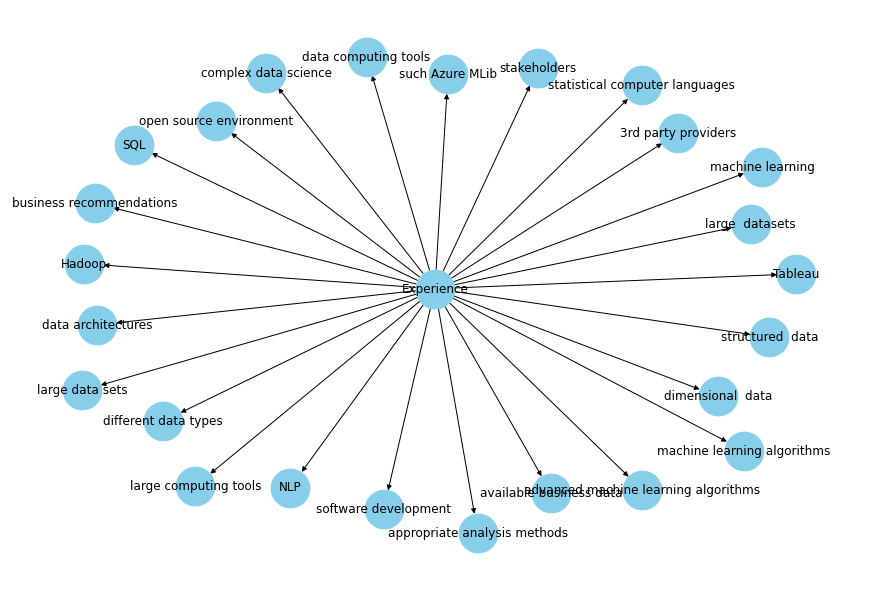

In [52]:
import networkx as nx
from networkx import MultiDiGraph
import matplotlib.pyplot as plt


G = nx.from_pandas_edgelist(exp_df, 
                            source = 'edge',
                            target = 'target',
                            edge_attr=True, create_using=MultiDiGraph())

plt.figure(figsize=(12,8))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, 
        node_color='skyblue',
        node_size = 1500, 
        edge_cmap=plt.cm.Blues, 
        pos = pos)


plt.show()

### "Looking For" Knowedge Graph


In [53]:
kg_df#.groupby('edge').size().sort_values(ascending=False)[:15]

source  ...              edge
0                        people  ...              Read
1                                ...              None
2                            We  ...               are
3                                ...              Join
4             Farmers Insurance  ...  offers extensive
...                         ...  ...               ...
294096                           ...      partner with
294097                           ...           improve
294098  automated learning that  ...            Select
294099             Requirements  ...          required
294100                 7  years  ...            skills

[294101 rows x 3 columns]

In [54]:
# get top targets of 'looking for' relationship
top_n = 25

# filter by experience 
looking4_targets = kg_df[kg_df['edge'] == 'looking for'] #| (kg_df['edge'] == 'seeking')]
print(looking4_targets)
looking4_targets = looking4_targets[looking4_targets['target']!='']

looking4_targets = looking4_targets.groupby('target').size().sort_values(ascending=False)

looking4_target_count = looking4_targets.values[:top_n]
looking4_targets = looking4_targets.index.values[:top_n]
print(len(looking4_targets))

# make df to graph
looking4_df = pd.DataFrame(columns=['source','target', 'edge'])
looking4_df['target'] = looking4_targets
print(len(looking4_df))
looking4_df.edge = 'Looking for'

                           source  ...         edge
114                            We  ...  looking for
138                      Data who  ...  looking for
158                            We  ...  looking for
227                Data Scientist  ...  looking for
336                           who  ...  looking for
...                           ...  ...          ...
293726                  Data that  ...  looking for
293852  leading Pharmaceutical NJ  ...  looking for
293958                         We  ...  looking for
293972      Geo Analysis Geo Team  ...  looking for
293980                       Team  ...  looking for

[2321 rows x 3 columns]
25
25


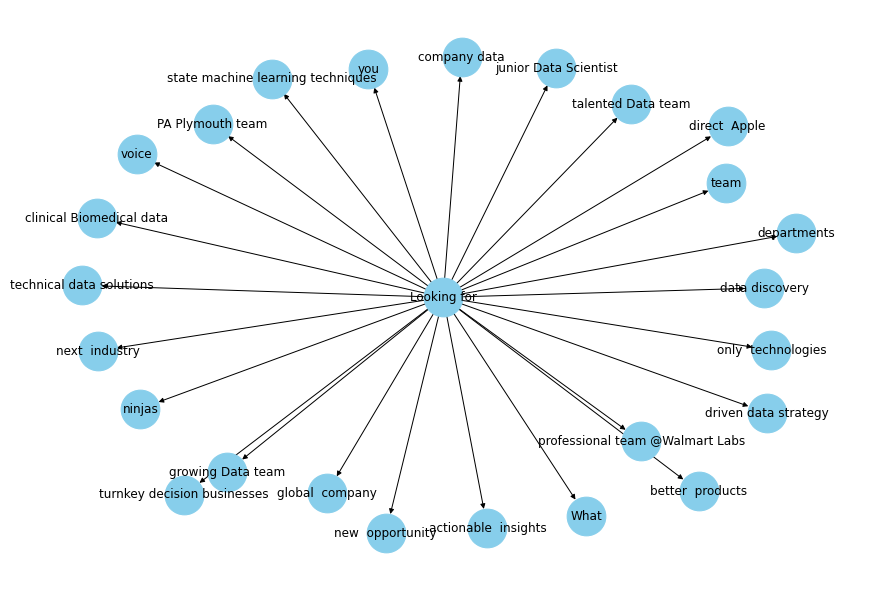

In [55]:
G = nx.from_pandas_edgelist(looking4_df, 
                            source = 'edge',
                            target = 'target',
                            edge_attr=True, create_using=MultiDiGraph())

plt.figure(figsize=(12,8))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, 
        node_color='skyblue',
        node_size = 1500, 
        edge_cmap=plt.cm.Blues, 
        pos = pos)


plt.show()

## Try to Graph all entities and relationships

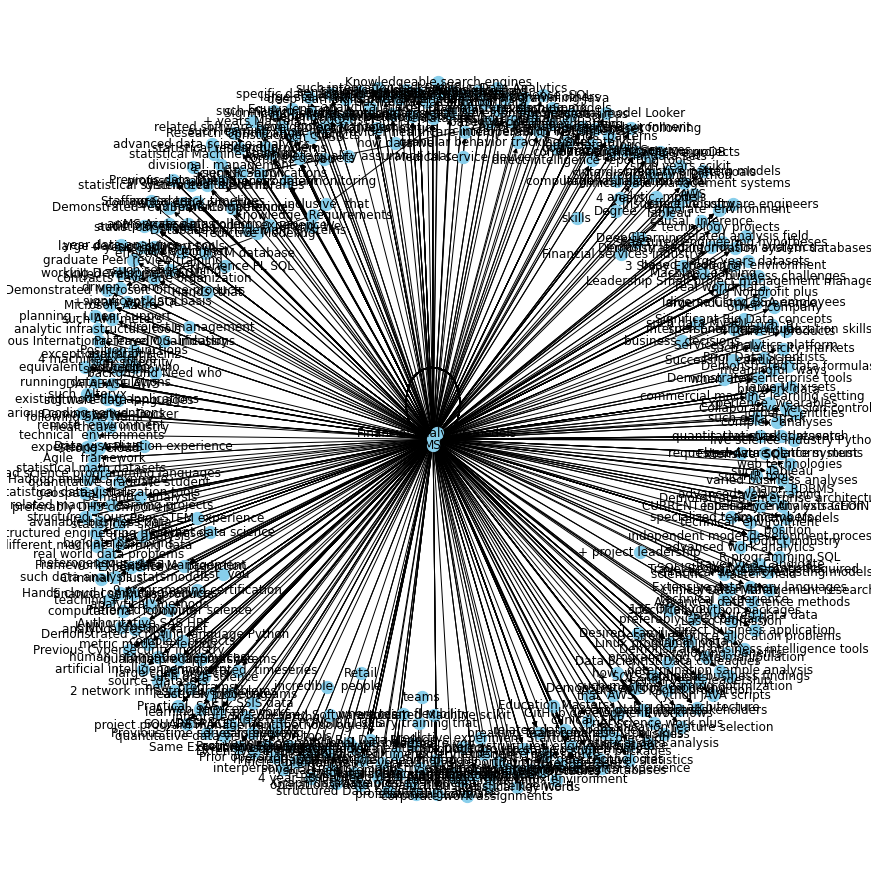

In [56]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == 'experience'], 
                            'source','target',
                            edge_attr=True, create_using=MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, 
        node_color='skyblue',
        node_size = 150, 
        edge_cmap=plt.cm.Blues, 
        pos = pos)

plt.show()

# Extract experiences and dependent nouns

In [57]:
from spacy.matcher import Matcher
def get_experience(job_doc):
  # use pattern matcher to find required experience and subsequent dependencies
  
  exp = 'experience'
  relation = ''
  prev_tok_text = ''
  prev_tok_dep = ''
  nouns = []
  
  # return none for empty docs
  if not isinstance(job_doc, spacy.tokens.doc.Doc):
    return 
  
  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern_exp = [{'DEP' : 'ROOT'},
                 {'LEMMA':'experience', 'OP': '?'},
                 ] 
  
  matcher.add("exp_pattern", [pattern_exp]) 
  matches = matcher(job_doc)

  # return none if no matches
  if len(matches) < 1:
    return 

  exp_idx = matches[0][0] + 1
  nc = job_doc.noun_chunks
  


  for i in nc:
    nouns += [i.text]
    #if nc[i].dep_!='compound':
  
  return nouns
      
  
  # 
  #for tok in sent_doc[exp_idx:]:
    # skip if punctuation
   # if tok.dep_ != 'punct':
      
    #  if (tok.dep_=='VERB') and (tok.dep_!=''):
     #   relation = tok.text
    
    #if tok.text == ':':
     # if



  #return(exp, relation, nouns)

In [58]:
# Observe the entities dependent on experience

relations = [get_experience(sent) for sent in tqdm(loaded_sents[:2000])]
relations

100%|██████████| 2000/2000 [00:00<00:00, 2791.89it/s]


[['what', 'people'],
 None,
 ['We', 'Farmers'],
 ['a team',
  'diverse professionals',
  'Farmers',
  'skills',
  'the job',
  'your learned knowledge',
  'future roles',
  'Farmers'],
 ['Farmers Insurance',
  'extensive training opportunities',
  'the award',
  'University',
  'Farmers',
  'Training magazine',
  'top 10 corporate training units',
  'the world'],
 ['your career', 'Farmers'],
 None,
 None,
 ['I',
  'a valuable part',
  'the Data Science team',
  'who',
  'statistical analysis',
  'modeling',
  'ualization services',
  'all lines',
  'business',
  'all shared service functions',
  'Farmers Insurance Group'],
 ['The Data Scientist', 'end', 'end solutions', 'part', 'a team'],
 ['They',
  'innovative analytic models',
  'cleaning datasets',
  'models',
  'results',
  'internal teams'],
 None,
 None,
 ['Extract data',
  'a variety',
  'sources',
  'databases',
  'web',
  'text files',
  'a variety',
  'formats',
  'the data',
  'analysis',
  'data',
  'qualitative and quanti

# Topic Modeling

## Vectorize job description text

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

# init vectorizer
vectorizer = TfidfVectorizer()

# get plain text as list
job_desc_text = data.job_dscrptn_docs.values.tolist()

text_lemma = []
for doc in job_desc_text:
  lem = ''
  for token in doc:
    if not token.is_stop and not token.is_punct:
      
      lem += ' '+token.lemma_.lower()
  
  text_lemma.append(lem)

In [61]:
# fit data to tfidf
job_desc_vecs = vectorizer.fit_transform(text_lemma)

## Find Best K

In [62]:
from sklearn.cluster import KMeans

# SSD since there's no ground truth
Sum_squared_distances = []
k_range = range(3,12)

# get SSD for each K
for k in k_range:
   km = KMeans(n_clusters = k, max_iter = 220, n_init = 9)
   km = km.fit(job_desc_vecs)
   Sum_squared_distances.append(km.inertia_)

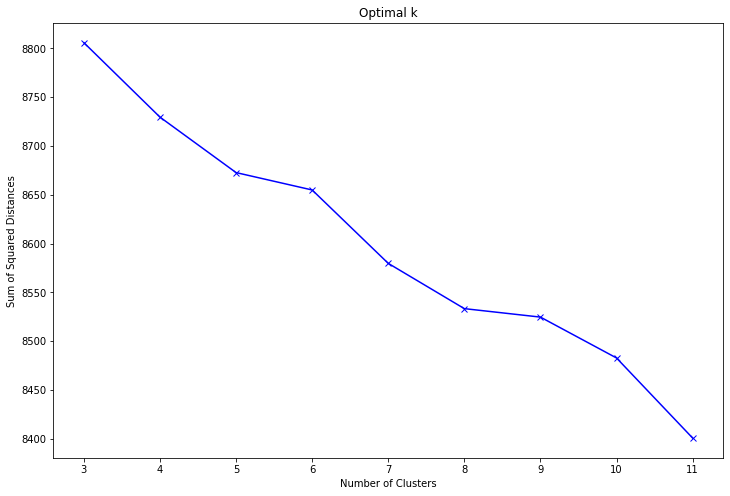

In [63]:
# plot optimal K
plt.figure(figsize=(12,8))
plt.plot(k_range, Sum_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Optimal k')
plt.show()

## Examine Clusters

In [64]:
# examine clustering with k= 7

clust_model = KMeans(
    n_clusters = 7,
    max_iter = 200, 
    n_init = 12)

clust_model.fit(job_desc_vecs) 

KMeans(max_iter=200, n_clusters=7, n_init=12)

In [65]:
import numpy as np

data['km_cluster'] = clust_model.labels_
data['km_SSD'] = clust_model.inertia_

top_clusters = data.sort_values(['km_cluster','km_SSD']).groupby('km_cluster')
top_clusters = top_clusters[['km_cluster','job_title','job_description']].head(3)

url = '/content/gdrive/Shareddrives/IST_736_Text_Mining/clusters.csv'
top_clusters.to_csv(url, index = False)

# Visualizations

## Word Cloud

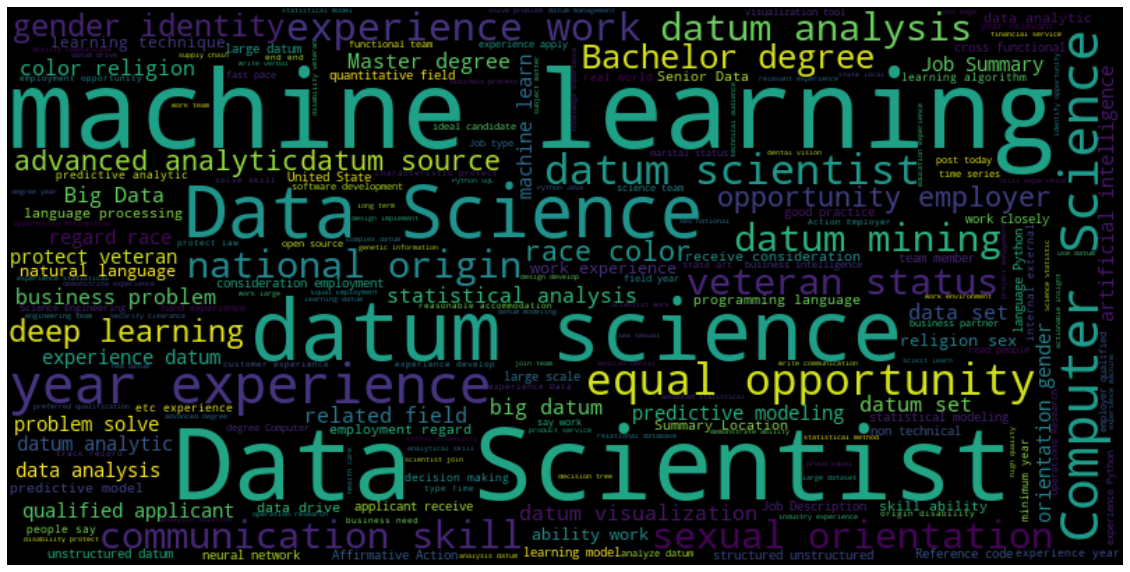

In [66]:
# Make word cloud
from pandas.core.common import flatten
from wordcloud import WordCloud, STOPWORDS

def clean_for_wc(text_doc):
  clean_tokens = [token.lemma_ for token in text_doc 
                  if token.is_alpha 
                  if not token.is_stop]
  return clean_tokens

# get list of text from docs
word_cloud_text = data.job_dscrptn_docs.apply(lambda x: clean_for_wc(x))
word_cloud_text = ' '.join(list(flatten(word_cloud_text)))

# generate word cloud
wordcloud = WordCloud(width=800, height=400, ).generate(word_cloud_text)

# plot wordcloud
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Clustered Word Cloud

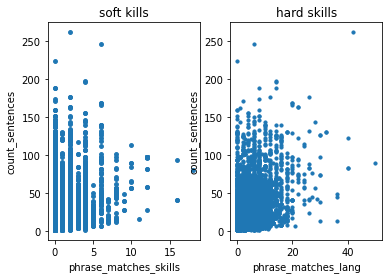

In [67]:
### visual interpretation , creating a subset of the dataset 
columns_list = data[['noun_list',
       'common_nouns', 'verb_list', 'common_verbs', 'phrase_matches_skills',
       'is_matches_skills', 'phrase_matches_lang', 'is_matches_com_lang',
       'count_sentences']]
data_visualization = columns_list.copy()
data_visualization.head(2)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(x='phrase_matches_skills',y='count_sentences', data=data_visualization, s=15) #hue= , #style=)
ax2.scatter(x='phrase_matches_lang',y='count_sentences', data=data_visualization, s=10) #hue= , #style=)

ax1.set_title('soft kills')
ax1.set_xlabel('phrase_matches_skills')
ax1.set_ylabel('count_sentences')

ax2.set_title('hard skills')
ax2.set_xlabel('phrase_matches_lang')
ax2.set_ylabel('count_sentences')
plt.show()


In [68]:
# Word cloud for each cluster

def make_wc(docs_list, km_clust):
  tokens_clean = [clean_for_wc(doc) for doc in docs_list]

  # get list of text from docs
  word_cloud_text = ' '.join(list(flatten(tokens_clean)))
  
  stopwords = set(STOPWORDS)
  stopwords.add('Data Scientist')
  
  # generate word cloud
  wc = WordCloud(
      width = 1000,
      height = 500,
      background_color = 'black',
      max_words = 2000,
      contour_width = 3,
      stopwords=stopwords
  ).generate(word_cloud_text)

  # plot wordcloud
  plt.figure(figsize=(14,7))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')

### Get Word Cloud for each cluster

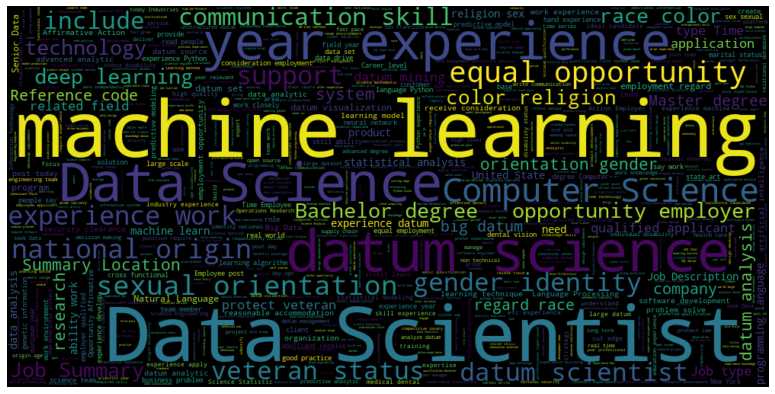

In [69]:
cluster = 0
clust_docs = data[data['km_cluster'] == cluster]['job_dscrptn_docs'].values.tolist()

make_wc(clust_docs, cluster)

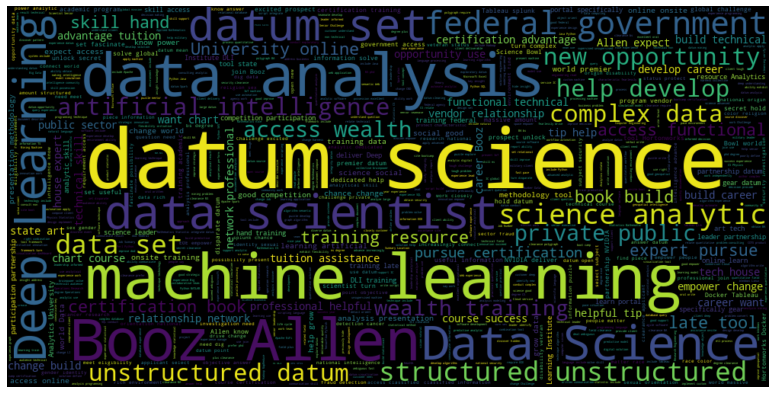

In [70]:
cluster = 1
clust_docs = data[data['km_cluster'] == cluster]['job_dscrptn_docs'].values.tolist()

make_wc(clust_docs, cluster)

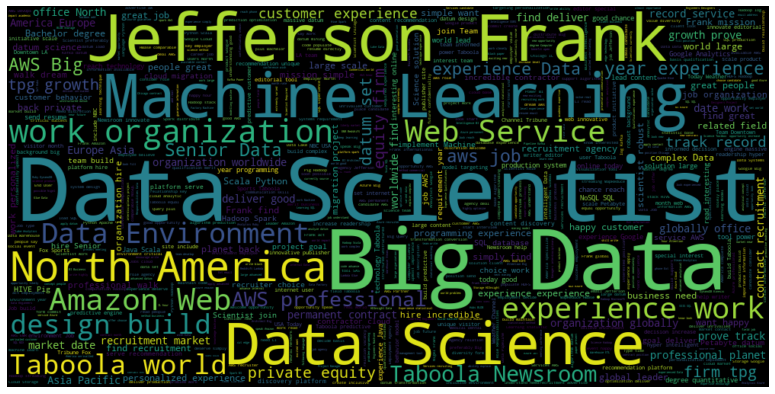

In [71]:
cluster = 2
clust_docs = data[data['km_cluster'] == cluster]['job_dscrptn_docs'].values.tolist()

make_wc(clust_docs, cluster)

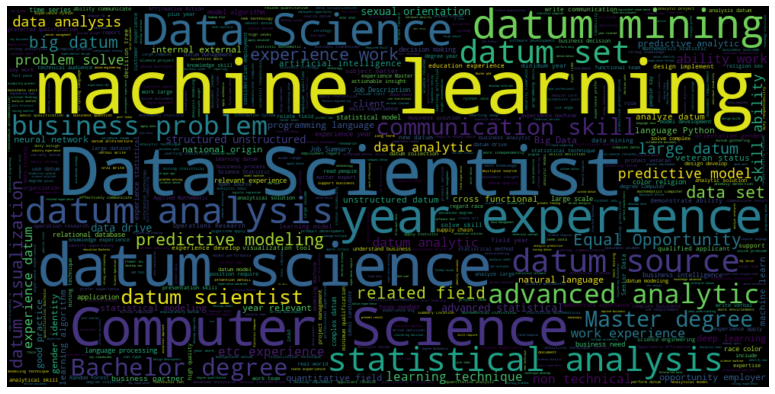

In [72]:
cluster = 3
clust_docs = data[data['km_cluster'] == cluster]['job_dscrptn_docs'].values.tolist()

make_wc(clust_docs, cluster)

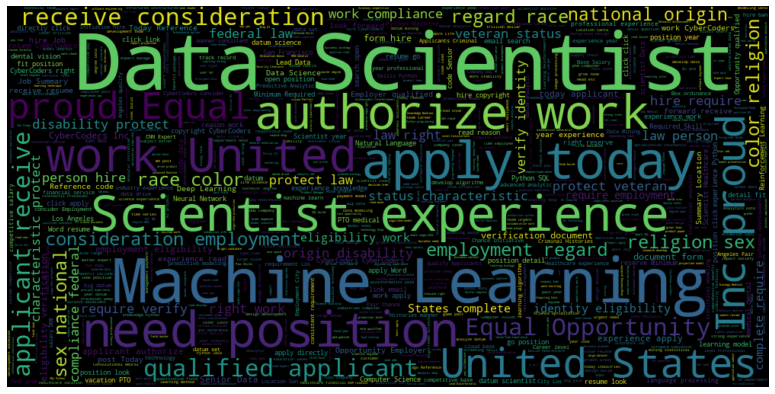

In [73]:
cluster = 4
clust_docs = data[data['km_cluster'] == cluster]['job_dscrptn_docs'].values.tolist()

make_wc(clust_docs, cluster)

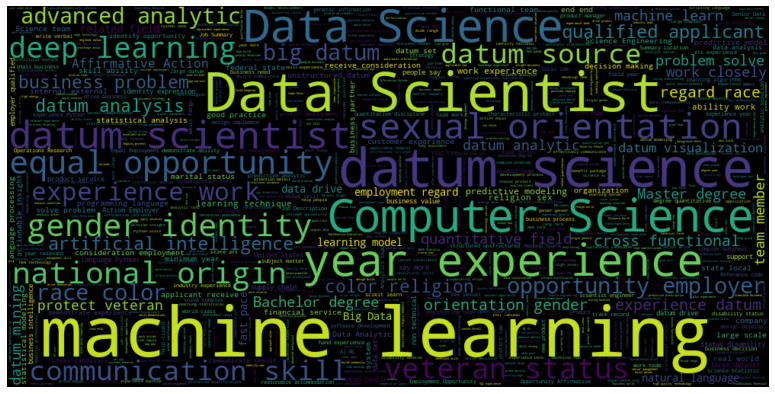

In [74]:
cluster = 5
clust_docs = data[data['km_cluster'] == cluster]['job_dscrptn_docs'].values.tolist()

make_wc(clust_docs, cluster)

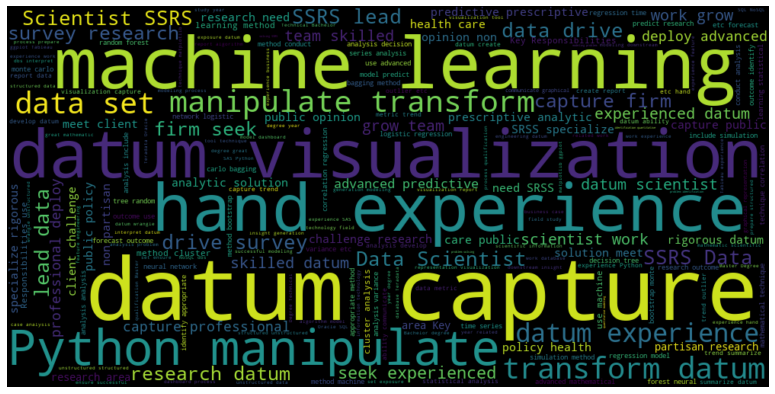

In [75]:
cluster = 6
clust_docs = data[data['km_cluster'] == cluster]['job_dscrptn_docs'].values.tolist()

make_wc(clust_docs, cluster)

# Other

In [76]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

In [77]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
        
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)  

In [78]:
tidy_docs = tidy_tokens(loaded_docs)

In [79]:
#tidy_docs = tidy_tokens(data['clean_job_dscrptn_docs'])

Each row represents a single token and the columns capture various metadata on that token. 

Importantly we can also link each individual word back to its doc using the `doc_id` column.


we can **count the number of words per doc** and visualise this with a histogram.

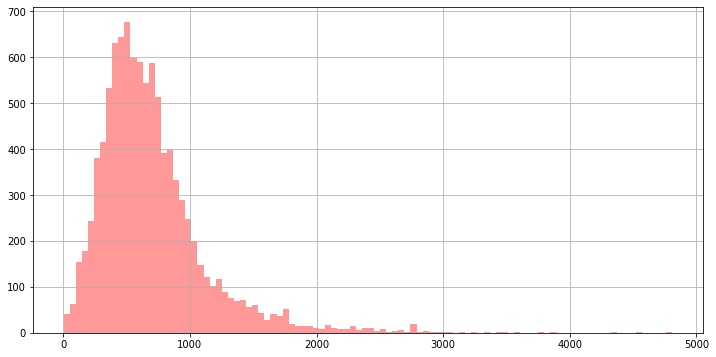

In [80]:
tidy_docs.groupby("doc_id").size().hist(figsize=(12,6), color="red", alpha=.4, bins=100);
#tidy_docs.groupby("pos == VERB").size().hist(figsize=(12,6), color="red", alpha=.4, bins=100);

seniority_level
entry/junior                 AxesSubplot(0.125,0.125;0.775x0.755)
other                        AxesSubplot(0.125,0.125;0.775x0.755)
senior                       AxesSubplot(0.125,0.125;0.775x0.755)
title_only_data_scientist    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

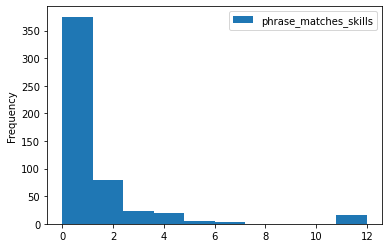

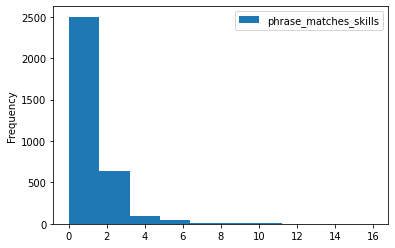

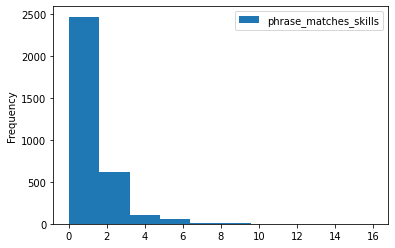

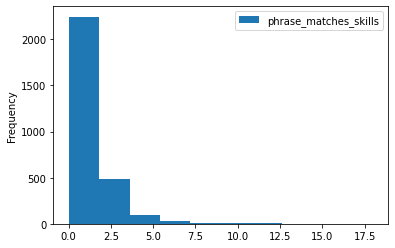

In [81]:
data.groupby('seniority_level').plot(kind='hist', x='seniority_level', y = 'phrase_matches_skills' )


seniority_level
entry/junior                 AxesSubplot(0.125,0.125;0.775x0.755)
other                        AxesSubplot(0.125,0.125;0.775x0.755)
senior                       AxesSubplot(0.125,0.125;0.775x0.755)
title_only_data_scientist    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

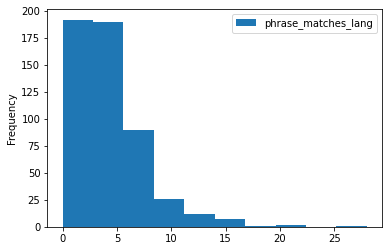

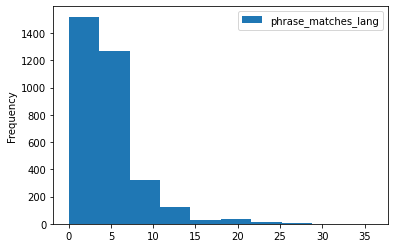

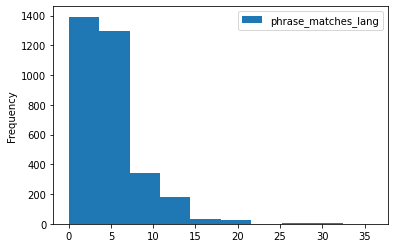

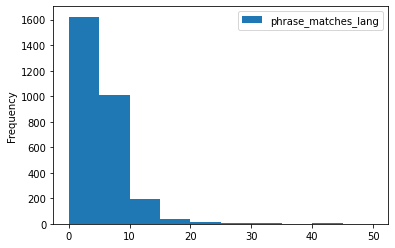

In [82]:
data.groupby('seniority_level').plot(kind='hist', x='seniority_level', y = 'phrase_matches_lang' )

distribution of **phrase_matches_skills** 

In [83]:
# data.groupby('job_title_clean').head(2)
# data.groupby('is_matches_com_lang').hist(figsize=(12,6), color="red", alpha=.4, bins=10)

is_matches_skills
0    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

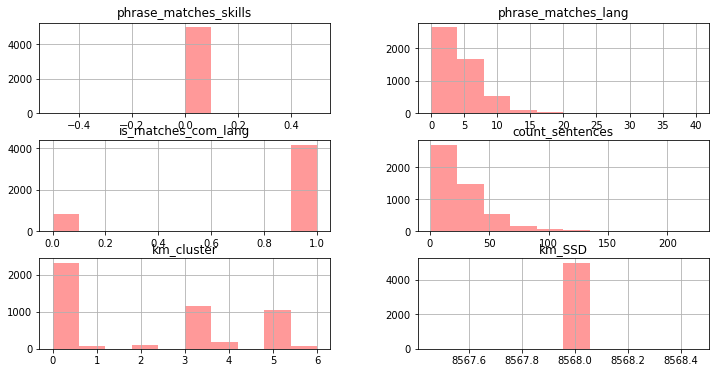

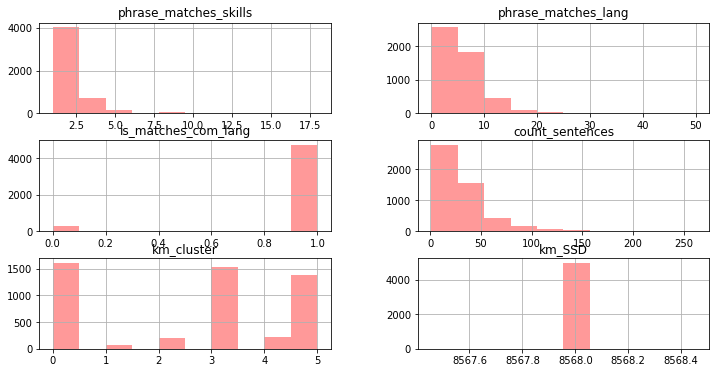

In [84]:
data.groupby('is_matches_skills').hist(figsize=(12,6), color="red", alpha=.4, bins=10)

we might be interested in understanding **the most common entities** that have been identified across the corpus

distribution of **phrase_matches_skills** 

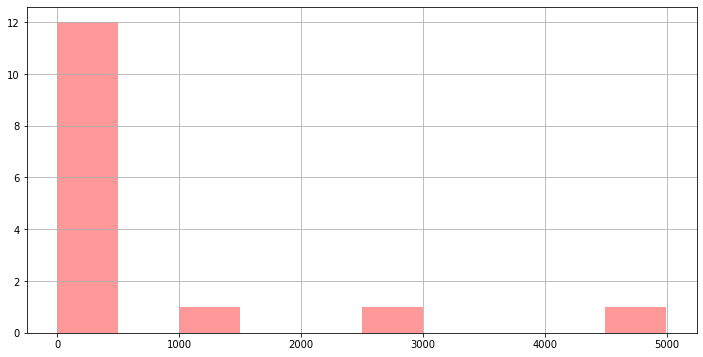

In [85]:
data.groupby('phrase_matches_skills').size().hist(figsize=(12,6), color="red", alpha=.4, bins=10)

In [86]:
#tidy_docs.query("ent_type != ''").ent_type.value_counts()
common_ents = tidy_docs.query("ent_type != ''").ent_type.value_counts()
print(common_ents)

ORG            332873
DATE            67564
GPE             31231
CARDINAL        29847
PERSON          15166
WORK_OF_ART     13835
PRODUCT          6596
PERCENT          5764
MONEY            5536
LOC              4582
LAW              3078
TIME             2506
NORP             2026
ORDINAL          1821
FAC              1796
QUANTITY         1010
EVENT             855
LANGUAGE          841
Name: ent_type, dtype: int64


(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000.]), <a list of 8 Text major ticklabel objects>)

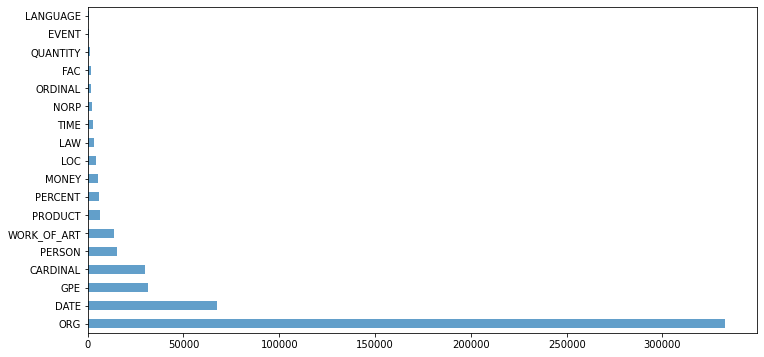

In [87]:
tidy_docs.query("ent_type != ''").ent_type.value_counts().head(30).plot(kind="barh", figsize=(12,6), alpha=.7)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

We can **count the most common words** after filtering out stop_words and puncutation


In [88]:
common_words = tidy_docs.query("is_stop == False & is_punct == False").lemma.value_counts()
print(common_words)

\n\n                 185454
datum                 81064
experience            57246
work                  41119
business              32845
                      ...  
workcollaborate           1
eyesin                    1
www.synectics.com         1
scripts                   1
Bxxx                      1
Name: lemma, Length: 42766, dtype: int64


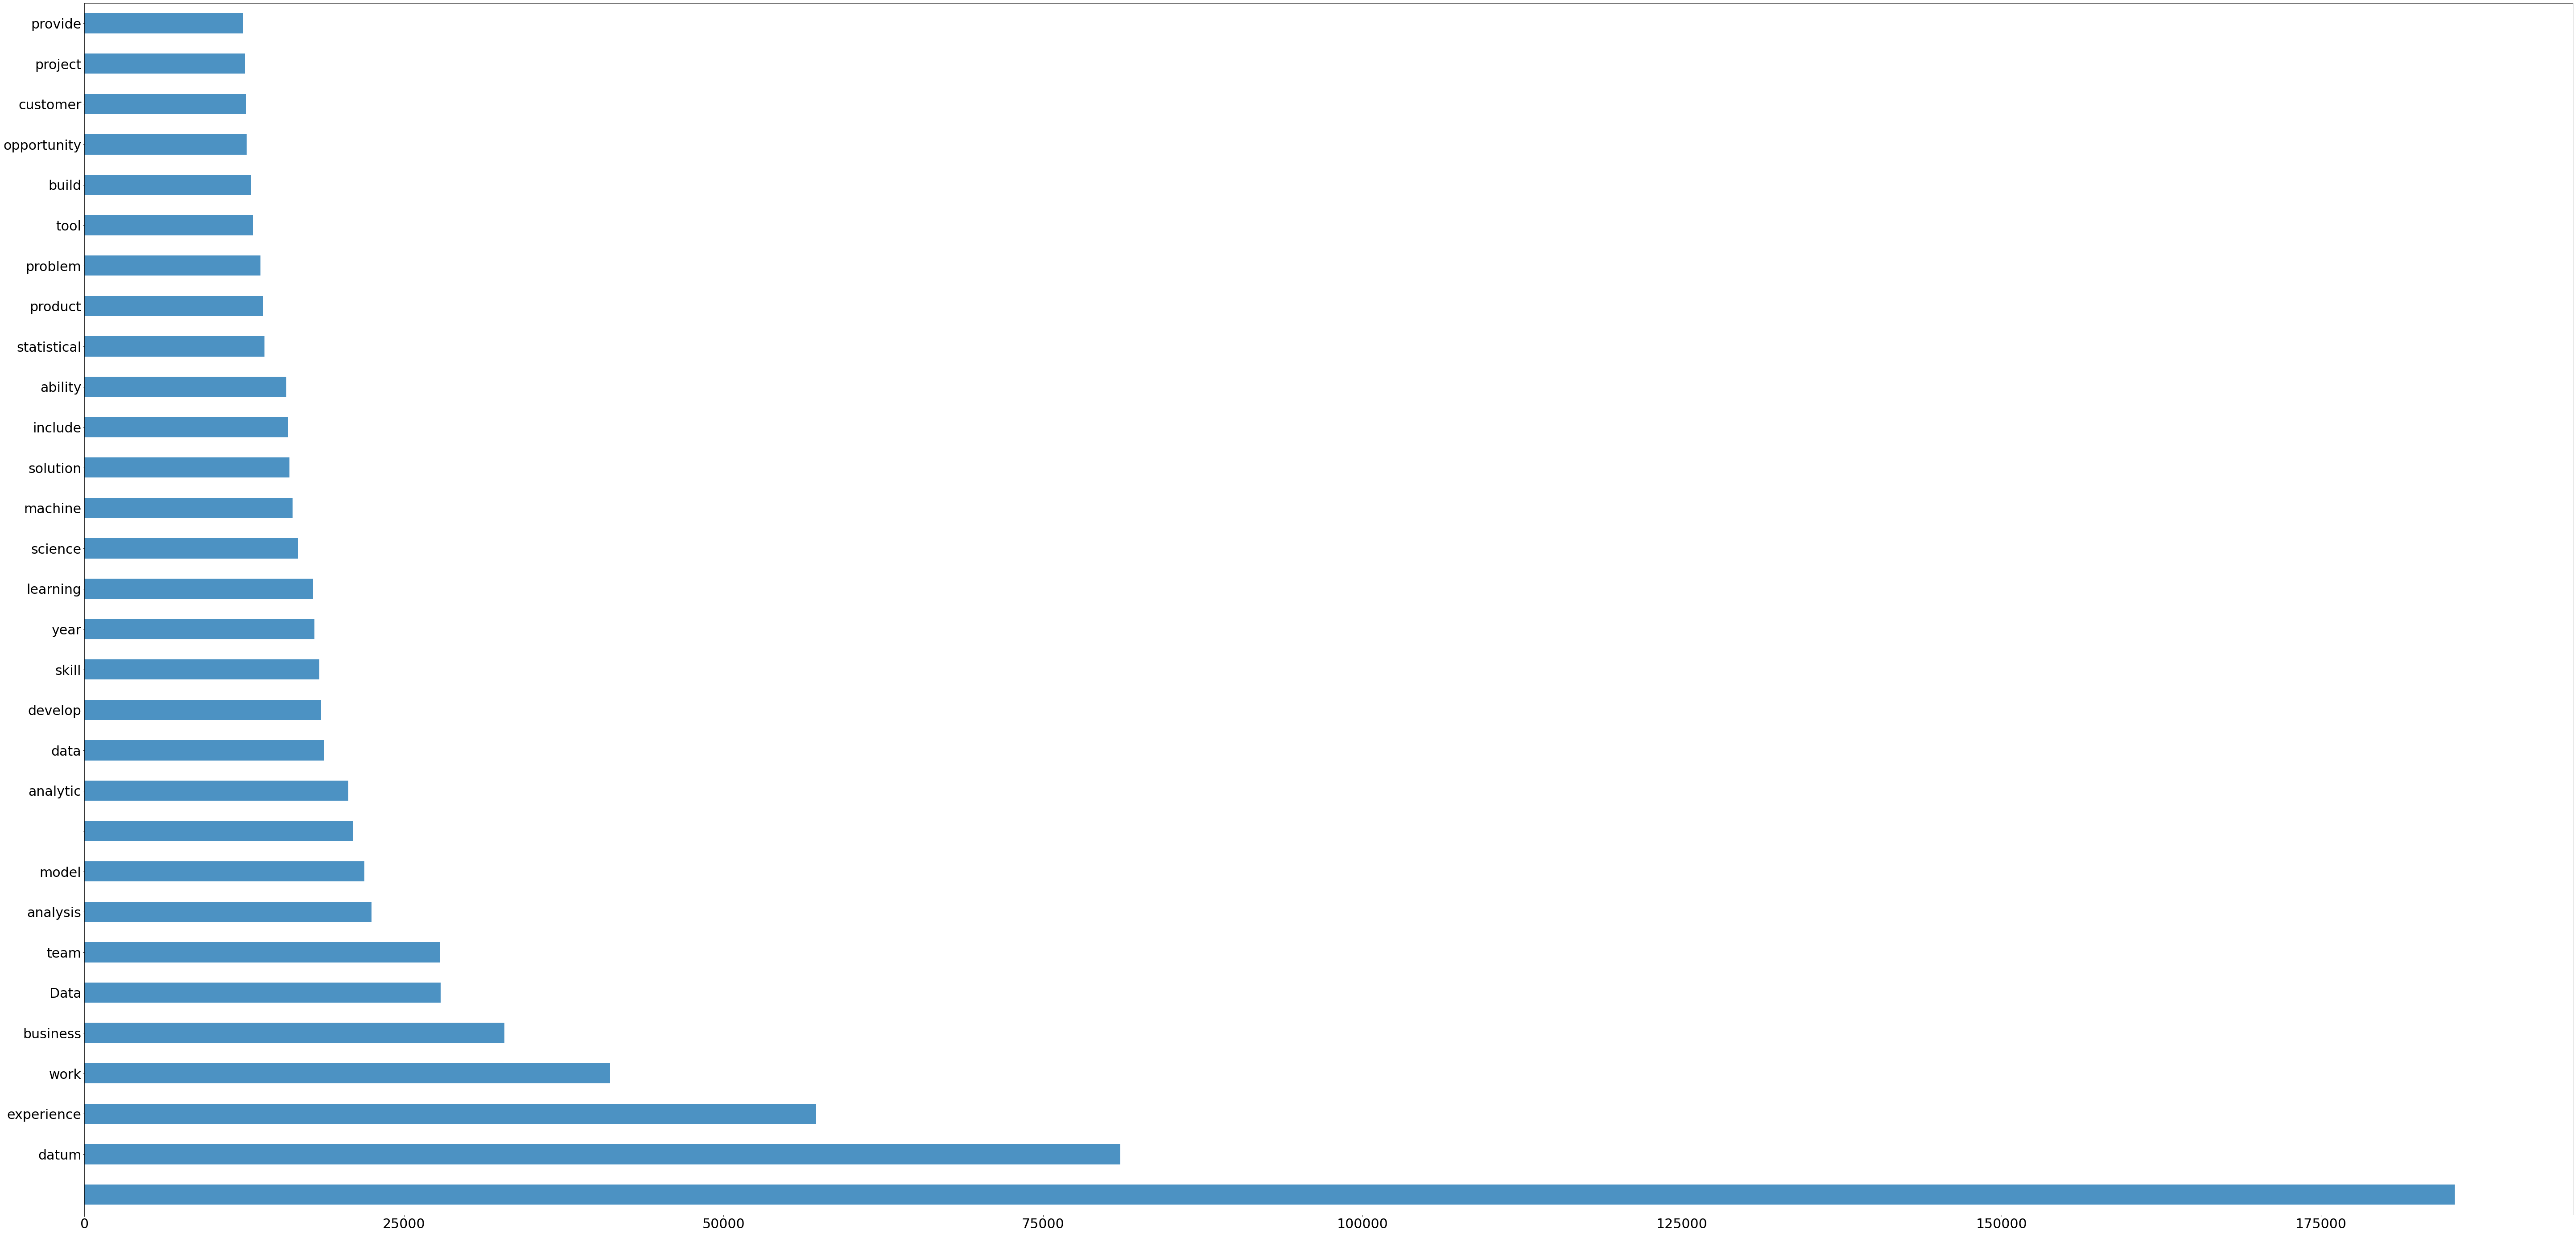

In [89]:
tidy_docs.query("is_stop == False & is_punct == False").lemma.value_counts().head(30).plot(kind="barh", figsize=(100, 50), alpha=.8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30);

**most commom VERBS**

In [90]:
common_verbs = tidy_docs.query("is_stop == False & is_punct == False & pos == 'VERB'").lemma.value_counts()
print(common_verbs)

work                                                               30016
develop                                                            18398
include                                                            15911
build                                                              12646
provide                                                            12412
                                                                   ...  
competencies                                                           1
http://www.eeoc.gov/employers/upload/eeoc_self_print_poster.pdf        1
anduse                                                                 1
ecommerce                                                              1
drive•                                                                 1
Name: lemma, Length: 3162, dtype: int64


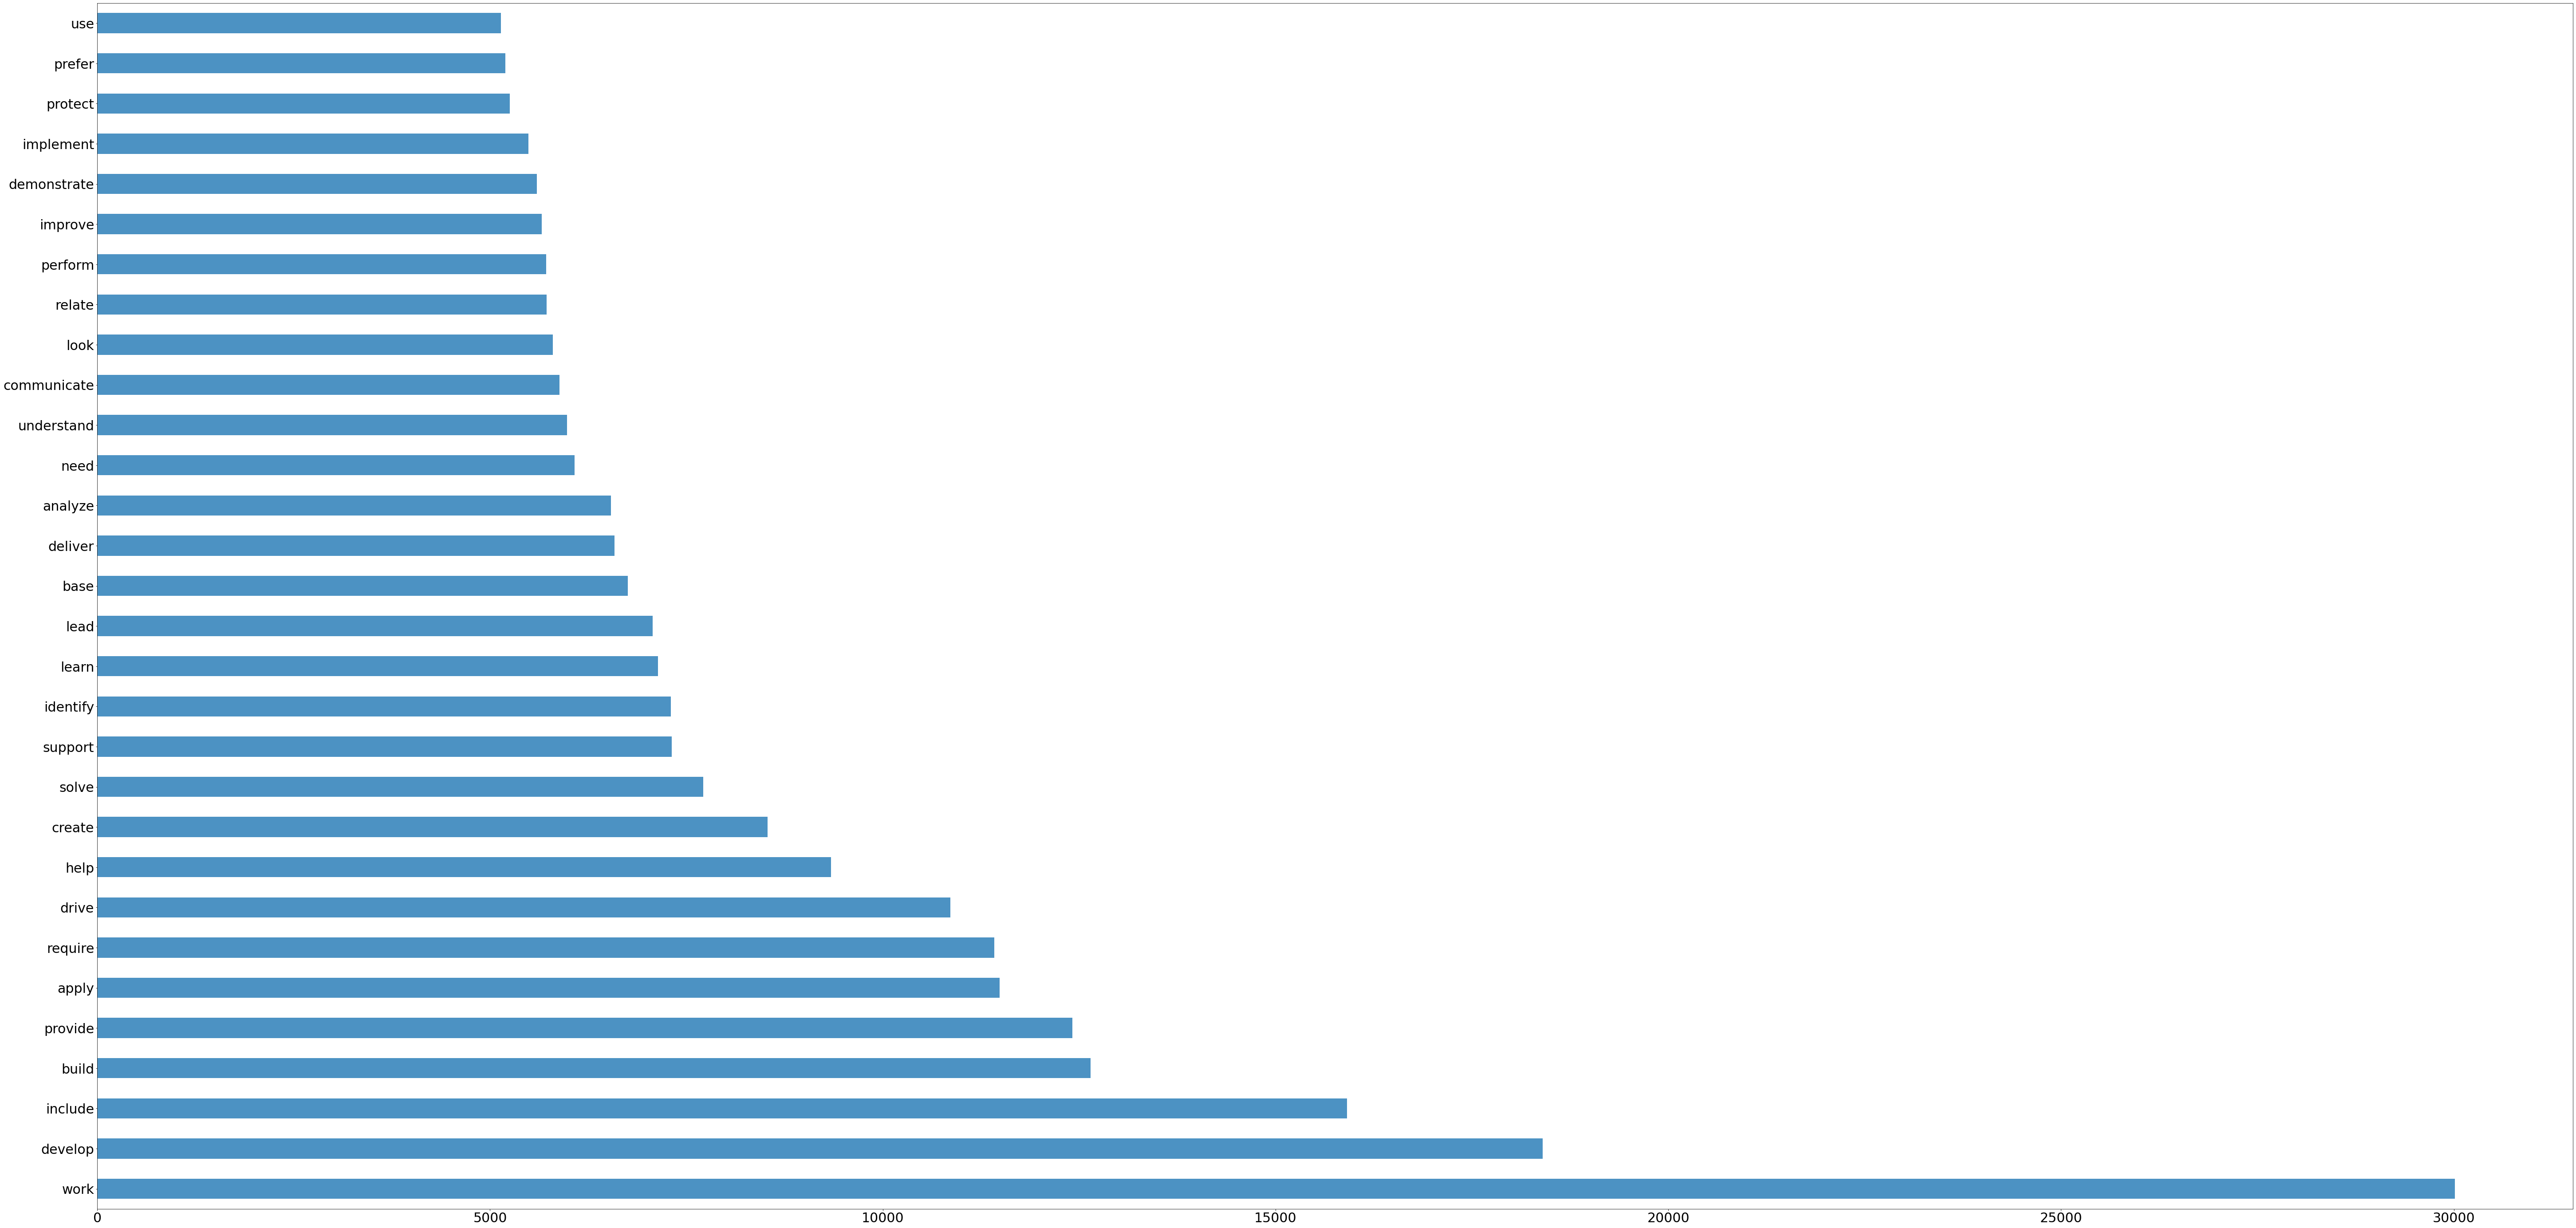

In [91]:
tidy_docs.query("is_stop == False & is_punct == False & pos == 'VERB'").lemma.value_counts().head(30).plot(kind="barh", figsize=(100, 50), alpha=.8)
plt.yticks(fontsize=30)
plt.xticks(fontsize=30);

We can **count the most common POS** after filtering out stop_words and puncutation

In [92]:
common_pos = tidy_docs.query("is_stop == False & is_punct == False")['pos'].value_counts().head(20)
print(common_pos)

NOUN     1868812
VERB      630680
PROPN     598854
ADJ       508078
SPACE     269223
NUM        59086
ADV        58090
X          11953
CCONJ       8312
ADP         4874
SYM         2068
AUX         1912
PUNCT       1266
INTJ         830
PRON         517
PART         284
DET          137
SCONJ        120
Name: pos, dtype: int64


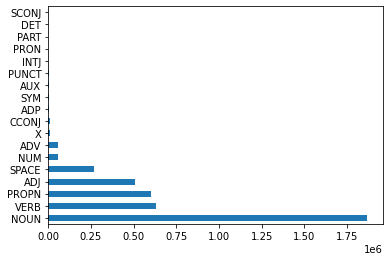

In [93]:
tidy_docs.query("is_stop == False & is_punct == False")['pos'].value_counts().head(20).plot(kind ='barh')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10);

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000.]), <a list of 8 Text major ticklabel objects>)

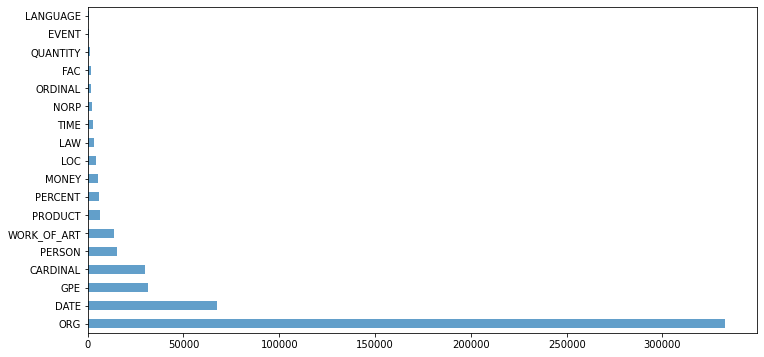

In [94]:
# tidy_docs.query("is_stop == False & is_punct == False").pos.value_counts().head(10).plot(kind="barh", figsize=(70, 30), alpha=.7)
# plt.yticks(fontsize=20)
# plt.xticks(fontsize=20);

tidy_docs.query("ent_type != ''").ent_type.value_counts().head(30).plot(kind="barh", figsize=(12,6), alpha=.7)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

 the code below looks at possessives to understand ownership within the corpus. 
 
The code below groups by each document then extracts the preceding and following token, then filters for tokens that are flagged with the `POS` tag, which indicates a *possessive relationship* i.e. the object of the previous token owns the subject of the following token.

This enables us to understand possessive relationships across the corpus. For example, you can see phrases such as, “One’s courage”, “someone’s prayers” and “today’s games”

In [95]:
(tidy_docs.groupby("doc_id").apply(lambda x: x.assign(prev_token = lambda x: x.token.shift(1), 
     next_token = lambda x: x.token.shift(-1))).reset_index(drop=True)
 .query("tag == 'POS'")
 .loc[:, ["doc_id", "prev_token", "token", "next_token"]]
)

doc_id   prev_token token     next_token
302           0       Master    's         degree
483           0      country    's        largest
742           2     Bachelor    ’s         degree
1260          3          API    ’s             to
1356          3    BlackRock    's       business
...         ...          ...   ...            ...
6971207    9996         Siri    's  computational
6971480    9997  realtor.com    's         wealth
6971493    9997      America    ’s           most
6971969    9998  realtor.com    's         wealth
6971982    9998      America    ’s           most

[22887 rows x 4 columns]